# Why Tensorflow

Here are my main reasons for opting for the use of tensorflow as possible for any machine learning model developement.

* You can design custom models that you would build from layers using the TF layers API, TF losses APIs and so on. If you're building something fairly standard, TensorFlow has a set of pre-made estimators that you can try out. Tensorflow 2 works well with keras models.

* As data and training time grows, your needs will increase. Checkpoints allow you to pause and resume training when needed, continue on training if the preset number of epochs happen to be insufficient.

* Your data doesn’t longer fit in memory? Tensorflow is designed with a dataset API that handles out of memory data sets. Tfrecords format also present an efficient format that works well with TensorFlow.

* You cannot train a large network over a large period of time without seeing how it’s doing. You can surface your defined key metrics during training that you can visualize in Tensorboard on both your training and validation set. Tensorboard is TensorFlow's visualization toolkit. TensorBoard provides the visualization and tooling needed for machine learning experimentation. TensorFlow metrics that are visualized in TensorBoard are computed during a training run and show how a metric changes against global training steps (across all training workers). This can answer questions such as “Is my model converging?”.

* Models train for hours, days, weeks. Optimizing a model that takes multiple weeks of training, is not workable. You have to distribute it on a cluster to make it faster. Going from one machine to many, might sound complicated, but with Tensorflow, you get distribution out of the box. TF abstracts away the details of distributed execution for training and evaluation, while also supporting consistent behavior across local/non-distributed and distributed configurations. There are many types of distribution architectures. Algorithms, like grading descent optimization, are not so easy, In the parameter server architecture, we'll need help from so-called parameter server to assist a pool of training workers. This parameter server forms a type of shared memory, and let each trainer learn from all the others.

# Steps

## Data Reading using tf.data. 

tf.data is a highly scalable toolkit for building data pipelines, and provides a few functions for dealing loading CSV files. We can use any of the following methods to read out-of-memory data:	
*	tf.data.experimental.make_csv_dataset
*	tf.data.experimental.CsvDataset
*	tf.data.TextLineDataset and tf.io.decode_csv
*	We should avoid using tf.data.Dataset.from_tensor_slices since this method reads data from in-memory dictionnaries.

We need to split the training dataset into training, validation, and testing to be able to perform the hyperparameter tuning and evaluate model on unseen data. 

With tf.data, we can easily use:

* Shuffling
* Batching

## Feature Engineering

We can use either tensorflow feature_columns or keras preprocessing layers. Here are some ideas:

* Normalization of numerical columns
* One hot encoding of categorical columns
* Some feature engineering strategies to test:
    * Bucketizing numerical columns
    * Hashing
    * Embedding sparse categorical columns if any.
    * Shared embeddings
    * Cross features
    
## Baseline Modeling

We can use either the Keras sequential API or the Keras function API.

We can try implementing the following scenarios to see if it can improve performance:
* L2 regularization
* Dropout regularization
* Batch Normalization

Callbacks we can implement:
* Early Stopping
* TensorBoard (to view model logs on tensorboard)
	

## Model Variance & Bias Analysis

We Plot the training and validation loss of your model as a function of the number of epochs to make sure that model is converging in the correct manner. We can also plot the learning curve to diagnose Variance & Bias and propose a way to solve high variance or high bias if it’s being detected.

	
## Hyperparameter tuning 

We can tune some of these hyperparameters instead of trying and guess the best options. Some of the hyperparameters we can tune:

* Number of nodes in hidden layers.
* Regularization parameter or dropout probability.
* Learning rate.
* Batch size.
* Optimizer.

# 0. Loading Libraries

In [1]:
#You need to install tensorflow_docs before
#!pip3 install -q git+https://github.com/tensorflow/docs

In [2]:
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

import numpy as np
import pandas as pd

import pathlib
import shutil

import os
import pkg_resources
import datetime

import IPython

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [3]:
print("tensorflow version:", tf.__version__)
print("numpy version:", np.__version__)
print("pandas version:", pd.__version__)
print("matplotlib:", pkg_resources.get_distribution("matplotlib").version)
print("scikit-learn:", pkg_resources.get_distribution("scikit-learn").version)

tensorflow version: 2.4.1
numpy version: 1.19.5
pandas version: 1.2.2
matplotlib: 3.3.4
scikit-learn: 0.24.1


In [4]:
logdir = pathlib.Path("logs_training")
shutil.rmtree(logdir, ignore_errors=True)

# 1. Reading data

In this part, we'll read data directly using tf.data and store them in a tf dataset.

The data are stored in a directory called `data`, and thus can be accessed with the following path `data/Sample_IssueDataset.csv`.

## Metadata about our data

Let's find out the number of features in our dataset and the number of distinct classes of our target.

We'll read only the head of our data in order to extract these information. No need to load all data into memory as this is not recommended.


In [5]:
file_path = "data/external_Microsoft_issueDataset.csv"
data = pd.read_csv(file_path, nrows=10)

cols = data.columns
num_cols = len(cols)

print("Columns:" , cols)
print("Number of columns:" , num_cols)

Columns: Index(['Access Level', 'BD877Training Completed', 'Department Code',
       'Email Domain', 'EmployeeTargetedOverPastYear', 'Gender (code)',
       'Social Media Activity (Scaled)', 'behaviorPattern2',
       'fraudTraining Completed', 'peerUsageMetric6', 'usageMetric2',
       'usageMetric5'],
      dtype='object')
Number of columns: 12


In [6]:
data.head()

,Access Level,BD877Training Completed,Department Code,Email Domain,EmployeeTargetedOverPastYear,Gender (code),Social Media Activity (Scaled),behaviorPattern2,fraudTraining Completed,peerUsageMetric6,usageMetric2,usageMetric5
0,2,0.0,24999,ox.ac.uk,0.0,0,0.0,0,1,5,0,7
1,2,0.0,10000,ox.ac.uk,1.0,1,NaN,0,0,4,0,1
2,0,0.0,10000,si.edu,1.0,1,0.0,0,1,0,0,3
3,2,1.0,54997,si.edu,0.0,0,1.0,1,0,5,1,7
4,1,1.0,10000,si.edu,1.0,1,0.0,2,0,5,0,7


## Reading data using tf.data.experimental.CsvDataset

There are many ways to read data directly to tf dataset:

* We can read data into memory using pandas, and then transform them into tf datasets using `tf.data.Dataset.from_tensor_slices`. This is not the recommended practice as we'll be reading the whole dataset into memory.

* We can read data using `tf.data.experimental.make_csv_dataset`, a nice function where we can provide the url of our data and other parameters such as batching, shufflng...

There are other two APIs that may be helpful for advanced users if your use-case doesn't fit the basic patterns.

* `tf.data.experimental.CsvDataset`: a lower level csv dataset constructor.

* `tf.io.decode_csv`: a function for parsing lines of text into a list of CSV column tensors.

Let's use `tf.data.experimental.CsvDataset`.

In [7]:
features_types = [float(), float(), str(), str(), float(), float(), float(), float(), float(), float(), float(), float()]

train = tf.data.experimental.CsvDataset("data/train.csv", record_defaults=features_types, header=True)
test = tf.data.experimental.CsvDataset("data/test.csv", record_defaults=features_types, header=True)

train = tf.data.Dataset.zip((train, ))
test = tf.data.Dataset.zip((test, ))


## Data Splits

In [8]:
train_size = train.reduce(0, lambda x, _: x + 1).numpy()
test_size = test.reduce(0, lambda x, _: x + 1).numpy()

print("Train dataset size:", train_size)
print("test dataset size:", test_size)

Train dataset size: 11214
test dataset size: 2786


## Preprocess dataset

Preprocess dataset includes:

* packing features into a dictionnary.

In [9]:
# fixing column names
cols_m = [x.replace(',','') for x in cols]
cols_m = [x.replace('(','') for x in cols_m]
cols_m = [x.replace(')','') for x in cols_m]
cols_m = [x.replace("\'",'') for x in cols_m]
cols_m = [x.replace(' ','_') for x in cols_m]

In [10]:
# A mapping function for tf dataset
def _preprocess_line(features):
    # Pack the result into a dictionary
    features = dict(zip(cols_m, features))
    target = features.pop("EmployeeTargetedOverPastYear")
    return features, target

train = train.map(_preprocess_line)
test= test.map(_preprocess_line)

In [11]:
cols_m

['Access_Level',
 'BD877Training_Completed',
 'Department_Code',
 'Email_Domain',
 'EmployeeTargetedOverPastYear',
 'Gender_code',
 'Social_Media_Activity_Scaled',
 'behaviorPattern2',
 'fraudTraining_Completed',
 'peerUsageMetric6',
 'usageMetric2',
 'usageMetric5']

In [12]:
for feature_batch, label_batch in train.batch(5).take(1):
    print('First 5 features:', list(feature_batch.keys())[:5])
    print('A batch of Access_Level:', feature_batch["Access_Level"].numpy())
    print('A batch of BD877Training_Completed:', feature_batch["BD877Training_Completed"].numpy())
    print('A batch of Email_Domain:', feature_batch["Email_Domain"].numpy())
    print('A batch of peerUsageMetric6:', feature_batch["peerUsageMetric6"].numpy())
    print('A batch of targets:', label_batch.numpy() ) 

First 5 features: ['Access_Level', 'BD877Training_Completed', 'Department_Code', 'Email_Domain', 'Gender_code']
A batch of Access_Level: [2. 2. 0. 2. 1.]
A batch of BD877Training_Completed: [0. 0. 0. 1. 1.]
A batch of Email_Domain: [b'ox.ac.uk' b'ox.ac.uk' b'si.edu' b'si.edu' b'si.edu']
A batch of peerUsageMetric6: [5. 4. 0. 5. 5.]
A batch of targets: [0. 1. 1. 0. 1.]


# 2. Feature Engineering with tf.feature_columns

We'll use tensorflow feature columns to prepare our features. We can also use tf keras preprocessing layers.

**The best thing about using feature columns and embed them in the model, is that you don't have to repeat the feature engineering process for new serving data.**

In [13]:
# numerical features
cols_numeric = []

# categorical ordinal features
cols_cat_ord = ["Access_Level", 
                "behaviorPattern2", 
                "peerUsageMetric6",
                "usageMetric2", 
                "usageMetric5",
                "Social_Media_Activity_Scaled"]

#
cols_cat_nom_1 = ['BD877Training_Completed', 'fraudTraining_Completed', 'Gender_code'] # already binary
cols_cat_nom_2 = ['Department_Code', 'Email_Domain'] # one hot encoding

cols_vocabulary_list = {
    'Department_Code': ["10000", "24999", "39998", "54997", "69996", "84995"],
    'Email_Domain': ['ox.ac.uk', 'si.edu', 'slideshare.net', 'google.co.uk', 'nsw.gov.au', 'ehow.com']
}

### Normalizing Numerical Features

In order to normalize the numerical features with feature columns, we need to provide it with the normalization function that should take the mean and std and normalize accordingly.

So we need to calculate these aggregarated stats in advance.

First let's select the numerical features of our training dataset. Those whose aggregated values are to be calculated.

In [14]:
#def extract_num_features(features, targets):
#    features = { key: features[key] for key in cols_numeric }
#    return features

#train_num_features = train.map(extract_num_features)

In [15]:
def extract_cat_ord_features(features, targets):
    features = { key: features[key] for key in cols_cat_ord }
    return features

train_cat_ord_features = train.map(extract_cat_ord_features)

The best way to calculate aggregates over tensorflow datasets is to use the `reduce` method. The transformation calls reduce_func successively on every element of the input dataset until the dataset is exhausted, aggregating information in its internal state. The initial_state argument is used for the initial state and the final state is returned as the result.

In [16]:
def features_aggregator_sum(x, y):
    features_sum = {key: x[key] + y[key] for key in cols_numeric}    
    return features_sum

def features_aggregator_sum_squared(x, y):
    features_sum = {key: x[key] + (y[key] - train_num_means[key]/train_size)**2 for key in cols_numeric}    
    return features_sum

#train_num_means = train_num_features.reduce({key: 0.0 for key in cols_numeric}, features_aggregator_sum)
#train_num_stds = train_num_features.reduce({key: 0.0 for key in cols_numeric}, features_aggregator_sum_squared)

#train_num_means = {key: train_num_means[key].numpy()/train_size for key in train_num_means}
#train_num_stds = {key: (train_num_stds[key].numpy()/train_size)**(1/2) for key in train_num_stds}

In [17]:
def features_aggregator_min(x, y):
    features_min = {key: tf.math.minimum(x[key], y[key]) for key in cols_cat_ord}    
    return features_min

def features_aggregator_max(x, y):
    features_max = {key: tf.math.maximum(x[key], y[key]) for key in cols_cat_ord}    
    return features_max


train_cat_ord_min = train_cat_ord_features.reduce({key: 1000.00 for key in cols_cat_ord}, features_aggregator_min)
train_cat_ord_max = train_cat_ord_features.reduce({key: -1000.00 for key in cols_cat_ord}, features_aggregator_max)

train_cat_ord_min = {key: train_cat_ord_min[key].numpy() for key in train_cat_ord_min}
train_cat_ord_max = {key: train_cat_ord_max[key].numpy() for key in train_cat_ord_max}

Let's now define the feature strategy for each feature depending on its type.

A numeric column is the simplest type of column. It is used to represent real valued features. When using this column, your model will receive the column value from the dataframe unchanged. We can also provide a numeric feature with a normalization function in order to normalize our features with our custom provided function.

In this dataset, we have features represented as a string. We cannot feed strings directly to a model. Instead, we must first map them to numeric values. The categorical vocabulary columns provide a way to represent strings as a one-hot vector (much like you have seen above with age buckets). The vocabulary can be passed as a list using categorical_column_with_vocabulary_list, or loaded from a file using categorical_column_with_vocabulary_file.

In [18]:
feature_columns = []

# numeric cols
for col_numeric in cols_numeric:
    feature_columns.append(tf.feature_column.numeric_column(col_numeric, normalizer_fn=lambda x: (x - train_num_means[col_numeric]) / train_num_stds[col_numeric]))

# categorical cols ordinal
for col_cat_ord in cols_cat_ord:
    feature_columns.append(tf.feature_column.numeric_column(col_cat_ord, normalizer_fn=lambda x: (x - train_cat_ord_min[col_cat_ord]) / (train_cat_ord_max[col_cat_ord] - train_cat_ord_min[col_cat_ord]) ))
    
# categorical cols ordinal 1 (binary already float type)
for col_cat_nom_1 in cols_cat_nom_1:
    feature_columns.append(tf.feature_column.numeric_column(col_cat_nom_1))
    
# categorical cols ordinal 2 (string to one hot code)
for col_cat_nom_2 in cols_cat_nom_2:
    categorical = tf.feature_column.categorical_column_with_vocabulary_list(
        col_cat_nom_2, cols_vocabulary_list[col_cat_nom_2])
    indicator = tf.feature_column.indicator_column(categorical)
    feature_columns.append(indicator)    
    


# 3. Create, compile, and train the model

In [19]:
history = {}

## 3.1 Baseline Model

Let's create our first baseline model. The model has 2 fully connected layers with 128 nodes each. The second layer is followed by a dropout layer. 

In [20]:
BATCH_SIZE = 256
N_EPOCHS = 100
STEPS_PER_EPOCH = train_size/BATCH_SIZE

In [21]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=STEPS_PER_EPOCH*1000,
  decay_rate=10,
  staircase=False)

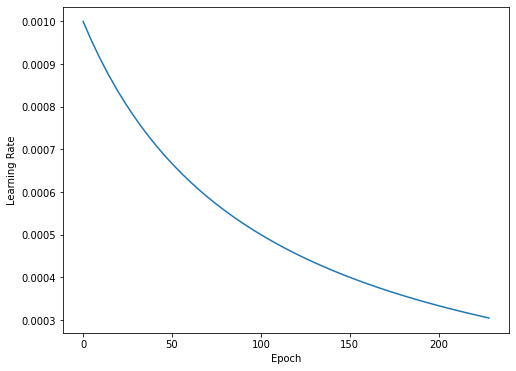

In [22]:
step = np.linspace(0,10000)
lr = lr_schedule(step)
plt.figure(figsize = (8,6))
plt.plot(step/STEPS_PER_EPOCH, lr)
#plt.ylim([0,max(plt.ylim())])
plt.xlabel('Epoch')
_ = plt.ylabel('Learning Rate')

In [23]:
def create_model():
    model = tf.keras.Sequential([
        tf.keras.layers.DenseFeatures(feature_columns),
        tf.keras.layers.Dense(256, activation="relu"),
        tf.keras.layers.Dense(128, activation="relu"),
        tfa.layers.WeightNormalization(tf.keras.layers.Dense(1, activation="sigmoid"))
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(lr_schedule),
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                  metrics=['accuracy'])
    return model

In [24]:
model_baseline = create_model()
#model.summary()

Let's batch our data.

In [25]:
train = train.batch(BATCH_SIZE)
test= test.batch(BATCH_SIZE)

We'll use two callbacks. The early stopping callback stops the training when the validation loss becomes stale. The tensorboard callback make sure the model logs are saved to a directory to be used by tensorboard later.

In [26]:
def get_callbacks(name):
    return [
        tfdocs.modeling.EpochDots(),
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=15),
        tf.keras.callbacks.TensorBoard(logdir/name),
    ]

model_name = "baseline"
history[model_name] = model_baseline.fit(train,
          validation_data=test,
          epochs=N_EPOCHS,
          callbacks=get_callbacks(model_name))

Epoch 1/100
44/44 [==============================] - 4s 61ms/step - loss: 0.4072 - accuracy: 0.8195 - val_loss: 0.2832 - val_accuracy: 0.9092

Epoch: 0, accuracy:0.8681,  loss:0.3476,  val_accuracy:0.9092,  val_loss:0.2832,  
.Epoch 2/100
44/44 [==============================] - 1s 20ms/step - loss: 0.2753 - accuracy: 0.9124 - val_loss: 0.2601 - val_accuracy: 0.9235
.Epoch 3/100
44/44 [==============================] - 1s 20ms/step - loss: 0.2534 - accuracy: 0.9276 - val_loss: 0.2523 - val_accuracy: 0.9289
.Epoch 4/100
44/44 [==============================] - 1s 19ms/step - loss: 0.2421 - accuracy: 0.9322 - val_loss: 0.2481 - val_accuracy: 0.9307
.Epoch 5/100
44/44 [==============================] - 1s 20ms/step - loss: 0.2342 - accuracy: 0.9356 - val_loss: 0.2451 - val_accuracy: 0.9311
.Epoch 6/100
44/44 [==============================] - 1s 19ms/step - loss: 0.2272 - accuracy: 0.9382 - val_loss: 0.2430 - val_accuracy: 0.9347
.Epoch 7/100
44/44 [==============================] - 1s 19

In [27]:
model_perf = model_baseline.evaluate(test)

print("Model binary cross entropy on validation set: {}".format(model_perf[0]))
print("Model accuracy on validation set: {}".format(model_perf[1]))

11/11 [==============================] - 0s 18ms/step - loss: 0.2488 - accuracy: 0.9354
Model binary cross entropy on validation set: 0.2487950325012207
Model accuracy on validation set: 0.9353912472724915


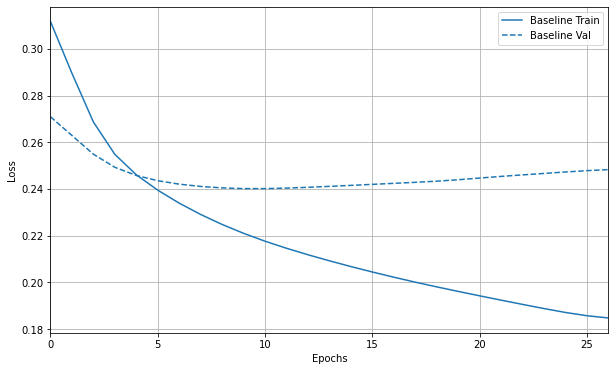

In [28]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'loss', smoothing_std=10)
plt.figure(figsize=(10, 6))
plotter.plot(history)

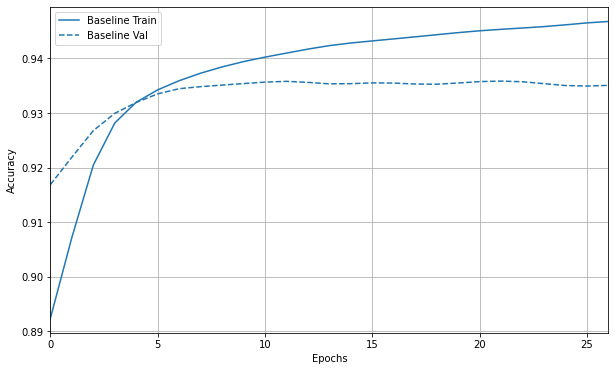

In [29]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'accuracy', smoothing_std=10)
plt.figure(figsize=(10, 6))
plotter.plot(history)

## 3.2. Experimenting with the model

We can experiment with the model to see how performance change over the validation set. For example, we can experiment adding batch normalization after each layer.

### 3.2.1. Small Model

In [30]:
def create_model():
    model = tf.keras.Sequential([
        tf.keras.layers.DenseFeatures(feature_columns),
        tf.keras.layers.Dense(512, activation="relu"),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(256, activation="relu"),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1, activation="sigmoid")
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(lr_schedule),
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                  metrics=['accuracy'])
    return model

In [31]:
model_small = create_model()
#model.summary()

In [32]:
def get_callbacks(name):
    return [
        tfdocs.modeling.EpochDots(),
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=15),
        tf.keras.callbacks.TensorBoard(logdir/name),
    ]


model_name = "small"
history[model_name] = model_small.fit(train,
          validation_data=test,
          epochs=N_EPOCHS,
          callbacks=get_callbacks(model_name))

Epoch 1/100
44/44 [==============================] - 2s 30ms/step - loss: 0.4832 - accuracy: 0.7729 - val_loss: 0.2854 - val_accuracy: 0.9124

Epoch: 0, accuracy:0.8375,  loss:0.3938,  val_accuracy:0.9124,  val_loss:0.2854,  
.Epoch 2/100
44/44 [==============================] - 1s 20ms/step - loss: 0.2859 - accuracy: 0.9076 - val_loss: 0.2576 - val_accuracy: 0.9250
.Epoch 3/100
44/44 [==============================] - 1s 19ms/step - loss: 0.2572 - accuracy: 0.9240 - val_loss: 0.2455 - val_accuracy: 0.9296
.Epoch 4/100
44/44 [==============================] - 1s 21ms/step - loss: 0.2472 - accuracy: 0.9313 - val_loss: 0.2406 - val_accuracy: 0.9329
.Epoch 5/100
44/44 [==============================] - 1s 20ms/step - loss: 0.2381 - accuracy: 0.9329 - val_loss: 0.2373 - val_accuracy: 0.9361
.Epoch 6/100
44/44 [==============================] - 1s 21ms/step - loss: 0.2345 - accuracy: 0.9363 - val_loss: 0.2352 - val_accuracy: 0.9368
.Epoch 7/100
44/44 [==============================] - 1s 20

In [33]:
model_perf = model_small.evaluate(test)

print("Model binary cross entropy on validation set: {}".format(model_perf[0]))
print("Model accuracy on validation set: {}".format(model_perf[1]))

11/11 [==============================] - 0s 14ms/step - loss: 0.2616 - accuracy: 0.9415
Model binary cross entropy on validation set: 0.26164698600769043
Model accuracy on validation set: 0.9414931535720825


### 3.2.2. Medium Model

In [34]:
def create_model():
    model = tf.keras.Sequential([
        tf.keras.layers.DenseFeatures(feature_columns),
        tf.keras.layers.Dense(1024, activation="relu"),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1024, activation="relu"),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(512, activation="relu"),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1, activation="sigmoid")
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(lr_schedule),
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                  metrics=['accuracy'])
    return model

In [35]:
model_medium = create_model()
#model.summary()

In [36]:
def get_callbacks(name):
    return [
        tfdocs.modeling.EpochDots(),
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=15),
        tf.keras.callbacks.TensorBoard(logdir/name),
    ]


model_name = "medium"
history[model_name] = model_medium.fit(train,
          validation_data=test,
          epochs=N_EPOCHS,
          callbacks=get_callbacks(model_name))

Epoch 1/100
44/44 [==============================] - 3s 39ms/step - loss: 0.4574 - accuracy: 0.7783 - val_loss: 0.2641 - val_accuracy: 0.9156

Epoch: 0, accuracy:0.8474,  loss:0.3773,  val_accuracy:0.9156,  val_loss:0.2641,  
.Epoch 2/100
44/44 [==============================] - 1s 30ms/step - loss: 0.2837 - accuracy: 0.9035 - val_loss: 0.2408 - val_accuracy: 0.9293
.Epoch 3/100
44/44 [==============================] - 1s 32ms/step - loss: 0.2581 - accuracy: 0.9131 - val_loss: 0.2347 - val_accuracy: 0.9325
.Epoch 4/100
44/44 [==============================] - 2s 35ms/step - loss: 0.2481 - accuracy: 0.9229 - val_loss: 0.2278 - val_accuracy: 0.9336
.Epoch 5/100
44/44 [==============================] - 1s 28ms/step - loss: 0.2367 - accuracy: 0.9279 - val_loss: 0.2271 - val_accuracy: 0.9332
.Epoch 6/100
44/44 [==============================] - 3s 72ms/step - loss: 0.2328 - accuracy: 0.9292 - val_loss: 0.2224 - val_accuracy: 0.9350
.Epoch 7/100
44/44 [==============================] - 1s 27

In [37]:
model_perf = model_medium.evaluate(test)

print("Model binary cross entropy on validation set: {}".format(model_perf[0]))
print("Model accuracy on validation set: {}".format(model_perf[1]))

11/11 [==============================] - 0s 12ms/step - loss: 0.2349 - accuracy: 0.9397
Model binary cross entropy on validation set: 0.23486201465129852
Model accuracy on validation set: 0.9396985173225403


### 3.2.3. Big Model

In [38]:
def create_model():
    model = tf.keras.Sequential([
        tf.keras.layers.DenseFeatures(feature_columns),
        tf.keras.layers.Dense(2048, activation="relu"),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(2048, activation="relu"),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1024, activation="relu"),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(512, activation="relu"),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1, activation="sigmoid")
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(lr_schedule),
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                  metrics=['accuracy'])
    return model

In [39]:
model_big = create_model()
#model.summary()

In [40]:
def get_callbacks(name):
    return [
        tfdocs.modeling.EpochDots(),
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=15),
        tf.keras.callbacks.TensorBoard(logdir/name),
    ]


model_name = "big"
history[model_name] = model_big.fit(train,
          validation_data=test,
          epochs=N_EPOCHS,
          callbacks=get_callbacks(model_name))

Epoch 1/100
44/44 [==============================] - 5s 95ms/step - loss: 0.4401 - accuracy: 0.7884 - val_loss: 0.2554 - val_accuracy: 0.9131

Epoch: 0, accuracy:0.8612,  loss:0.3574,  val_accuracy:0.9131,  val_loss:0.2554,  
.Epoch 2/100
44/44 [==============================] - 4s 92ms/step - loss: 0.2677 - accuracy: 0.9097 - val_loss: 0.2365 - val_accuracy: 0.9268
.Epoch 3/100
44/44 [==============================] - 4s 88ms/step - loss: 0.2426 - accuracy: 0.9241 - val_loss: 0.2333 - val_accuracy: 0.9340
.Epoch 4/100
44/44 [==============================] - 4s 86ms/step - loss: 0.2352 - accuracy: 0.9322 - val_loss: 0.2237 - val_accuracy: 0.9372
.Epoch 5/100
44/44 [==============================] - 4s 86ms/step - loss: 0.2284 - accuracy: 0.9324 - val_loss: 0.2257 - val_accuracy: 0.9343
.Epoch 6/100
44/44 [==============================] - 4s 89ms/step - loss: 0.2344 - accuracy: 0.9307 - val_loss: 0.2244 - val_accuracy: 0.9340
.Epoch 7/100
44/44 [==============================] - 4s 87

In [41]:
model_perf = model_big.evaluate(test)

print("Model binary cross entropy on validation set: {}".format(model_perf[0]))
print("Model accuracy on validation set: {}".format(model_perf[1]))

11/11 [==============================] - 0s 25ms/step - loss: 0.2648 - accuracy: 0.9375
Model binary cross entropy on validation set: 0.26479586958885193
Model accuracy on validation set: 0.9375448822975159


### 3.2.4 Batch Normalization

batch normalization helps training the weights and biases faster.

In [42]:
def create_model():
    model = tf.keras.Sequential([
        tf.keras.layers.DenseFeatures(feature_columns),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),
        tfa.layers.WeightNormalization(tf.keras.layers.Dense(2048, activation="relu")),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),
        tfa.layers.WeightNormalization(tf.keras.layers.Dense(2048, activation="relu")),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),
        tfa.layers.WeightNormalization(tf.keras.layers.Dense(1024, activation="relu")),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),
        tfa.layers.WeightNormalization(tf.keras.layers.Dense(512, activation="relu")),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),
        tfa.layers.WeightNormalization(tf.keras.layers.Dense(1, activation="sigmoid"))
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(lr_schedule),
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                  metrics=['accuracy'])
    return model

In [43]:
model_batch = create_model()
#model.summary()

In [44]:
def get_callbacks(name):
    return [
        tfdocs.modeling.EpochDots(),
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=15),
        tf.keras.callbacks.TensorBoard(logdir/name),
    ]


model_name = "batch"
history[model_name] = model_batch.fit(train,
          validation_data=test,
          epochs=N_EPOCHS,
          callbacks=get_callbacks(model_name))

Epoch 1/100
44/44 [==============================] - 15s 228ms/step - loss: 0.5238 - accuracy: 0.7795 - val_loss: 0.4409 - val_accuracy: 0.8568

Epoch: 0, accuracy:0.8251,  loss:0.4711,  val_accuracy:0.8568,  val_loss:0.4409,  
.Epoch 2/100
44/44 [==============================] - 8s 184ms/step - loss: 0.3848 - accuracy: 0.8557 - val_loss: 0.3046 - val_accuracy: 0.8920
.Epoch 3/100
44/44 [==============================] - 8s 186ms/step - loss: 0.3661 - accuracy: 0.8631 - val_loss: 0.2805 - val_accuracy: 0.8999
.Epoch 4/100
44/44 [==============================] - 8s 181ms/step - loss: 0.3400 - accuracy: 0.8699 - val_loss: 0.2828 - val_accuracy: 0.8984
.Epoch 5/100
44/44 [==============================] - 8s 191ms/step - loss: 0.3356 - accuracy: 0.8701 - val_loss: 0.2794 - val_accuracy: 0.9031
.Epoch 6/100
44/44 [==============================] - 9s 197ms/step - loss: 0.3287 - accuracy: 0.8716 - val_loss: 0.2757 - val_accuracy: 0.9063
.Epoch 7/100
44/44 [==============================] 

In [45]:
model_perf = model_batch.evaluate(test)

print("Model binary cross entropy on validation set: {}".format(model_perf[0]))
print("Model accuracy on validation set: {}".format(model_perf[1]))

11/11 [==============================] - 1s 40ms/step - loss: 0.2563 - accuracy: 0.9268
Model binary cross entropy on validation set: 0.25628039240837097
Model accuracy on validation set: 0.9267767667770386


# 4. Learning Process

## 4.1. Logs Plottinig

Let's check our training process by plotting the evaluation metric / loss vs the number of epochs.

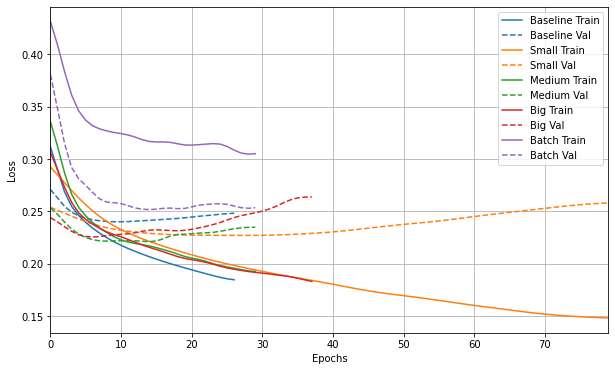

In [46]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'loss', smoothing_std=10)
plt.figure(figsize=(10, 6))
plotter.plot(history)

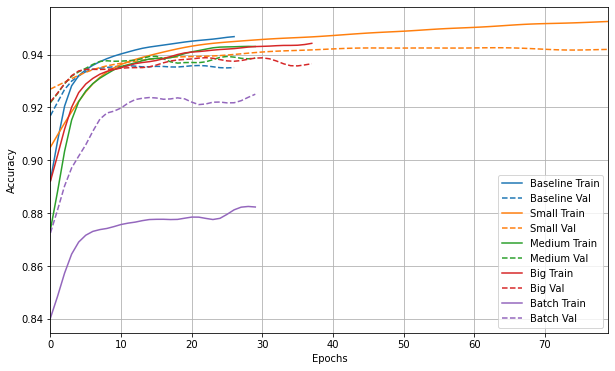

In [47]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'accuracy', smoothing_std=10)
plt.figure(figsize=(10, 6))
plotter.plot(history)

## 4.2. Tensorboard

In order to visualize tensorboard in jupyter notebook, we need to load tensorboard in ipython first:

In [48]:
%load_ext tensorboard

In [49]:
# I'm using a virtual env, so I need to be setting the `TENSORBOARD_BINARY` environment variable to tensorboard executable.
os.environ['TENSORBOARD_BINARY'] = 'pa_venv/bin/tensorboard'

Comparing training results across the different trained models:

In [50]:
%tensorboard --logdir logs_training

Reusing TensorBoard on port 6007 (pid 89614), started 1:18:29 ago. (Use '!kill 89614' to kill it.)

# 5. Assessing Model Metrics

## 5.1 AUC

In [51]:
# roc curve and auc score
from sklearn import metrics

In [52]:
# real labels and predicted scores

test = test.unbatch().batch(test_size)
for features, target in test.take(1):
    y_test = target.numpy()
y_test_pred = model_small.predict(test)

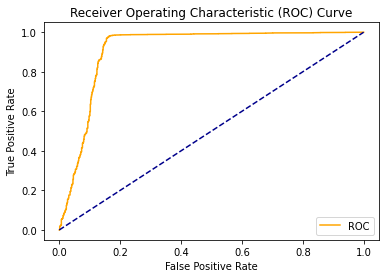

AUC-ROC : 0.9118156813361612


In [53]:
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

auc = metrics.roc_auc_score(y_test, y_test_pred)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_test_pred, pos_label=1)
plot_roc_curve(fpr, tpr)
print("AUC-ROC :",auc)

## 5.2 Precision - Recall vs Decision Threshold

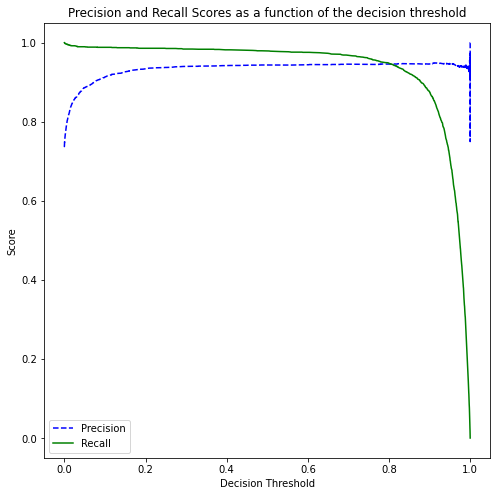

In [54]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    """
    Modified from:
    Hands-On Machine learning with Scikit-Learn
    and TensorFlow; p.89
    """
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')
    
precision, recall, thresholds = metrics.precision_recall_curve(y_test, y_test_pred, pos_label=1)
plot_precision_recall_vs_threshold(precision, recall, thresholds)

### Threshold Tuning

This depends on the context

In [55]:
THRESHOLD = 0.5

y_test_pred = y_test_pred > THRESHOLD

## 5.3. Metrics

In [56]:
metrics.confusion_matrix(y_test, y_test_pred)

array([[ 616,  120],
       [  43, 2007]])

In [57]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_test_pred))
# Recall
print("Recall:",metrics.recall_score(y_test, y_test_pred))
# Precision
print("Precison:",metrics.precision_score(y_test, y_test_pred))
# F1score
print("F1 Score:",metrics.f1_score(y_test, y_test_pred))

Accuracy: 0.9414931801866475
Recall: 0.9790243902439024
Precison: 0.9435825105782792
F1 Score: 0.9609767775915729


# 6. Save TF Model

In [58]:
# Had no time to perform hyperparameter tuning so I'll just pick the small model

In [59]:
!mkdir -p models
model_small.save('models/tf/model_small')

# 7. Holdout dataset

## 7.1. Loading saved Model

In [60]:
#final_model = tf.keras.models.load_model('models/tf/model_small')
# seems there's a bug or something in the new tf keras model! can't load saved model
# https://github.com/keras-team/keras/issues/11418

final_model = model_small

## 7.2. Reading and preparing holdout dataset

In [61]:
holdout = pd.read_csv("data/external_Microsoft_holdoutDataset.csv")
holdout = holdout[data.columns]
holdout.to_csv("data/external_Microsoft_holdoutDataset_ordered.csv", index=False)

holdout = tf.data.experimental.CsvDataset("data/external_Microsoft_holdoutDataset_ordered.csv", 
                                          record_defaults=features_types, 
                                          header=True)

holdout = tf.data.Dataset.zip((holdout, ))

In [62]:
holdout = holdout.map(_preprocess_line)

In [63]:
for feature_batch, label_batch in holdout.batch(5).take(1):
    print('First 5 features:', list(feature_batch.keys())[:5])
    print('A batch of Access_Level:', feature_batch["Access_Level"].numpy())
    print('A batch of BD877Training_Completed:', feature_batch["BD877Training_Completed"].numpy())
    print('A batch of Email_Domain:', feature_batch["Email_Domain"].numpy())
    print('A batch of peerUsageMetric6:', feature_batch["peerUsageMetric6"].numpy())
    print('A batch of targets:', label_batch.numpy() ) 

First 5 features: ['Access_Level', 'BD877Training_Completed', 'Department_Code', 'Email_Domain', 'Gender_code']
A batch of Access_Level: [2. 4. 1. 4. 1.]
A batch of BD877Training_Completed: [0. 0. 1. 0. 0.]
A batch of Email_Domain: [b'slideshare.net' b'nsw.gov.au' b'si.edu' b'ehow.com' b'slideshare.net']
A batch of peerUsageMetric6: [6. 0. 3. 2. 4.]
A batch of targets: [1. 1. 1. 1. 1.]


## 7.3 AUC

In [64]:
# roc curve and auc score
from sklearn import metrics

In [65]:
holdout_size = holdout.reduce(0, lambda x, _: x + 1).numpy()
holdout_size

1449

In [66]:
# real labels and predicted scores
holdout_size = holdout.reduce(0, lambda x, _: x + 1).numpy()

holdout = holdout.batch(holdout_size)

for features, target in holdout.take(1):
    y_holdout = target.numpy()
    
y_holdout_pred = final_model.predict(holdout)

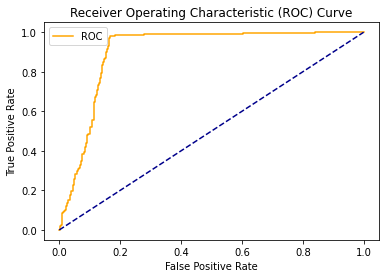

AUC-ROC : 0.9023538128627998


In [67]:
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

auc = metrics.roc_auc_score(y_holdout, y_holdout_pred)
fpr, tpr, thresholds = metrics.roc_curve(y_holdout, y_holdout_pred, pos_label=1)
plot_roc_curve(fpr, tpr)
print("AUC-ROC :",auc)

In [68]:
# Using tuned threshold
y_holdout_pred = (y_holdout_pred > THRESHOLD).astype(int)

## 7.4. Metrics

In [69]:
metrics.confusion_matrix(y_holdout, y_holdout_pred)

array([[ 318,   64],
       [  22, 1045]])

In [74]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_holdout, y_holdout_pred))
# Recall
print("Recall:",metrics.recall_score(y_holdout, y_holdout_pred))
# Precision
print("Precison:",metrics.precision_score(y_holdout, y_holdout_pred))
# F1score
print("F1 Score:",metrics.f1_score(y_holdout, y_holdout_pred))

Accuracy: 0.9406487232574189
Recall: 0.979381443298969
Precison: 0.9422903516681695
F1 Score: 0.9604779411764705


## 7.5. Saving Predictions

In [75]:
holdout = pd.read_csv("data/external_Microsoft_holdoutDataset.csv")
holdout["prediction"] = y_holdout_pred

In [76]:
holdout.head()

,EmployeeTargetedOverPastYear,Access Level,behaviorPattern2,peerUsageMetric6,usageMetric2,usageMetric5,Social Media Activity (Scaled),BD877Training Completed,Department Code,Email Domain,fraudTraining Completed,Gender (code),prediction
0,1.0,2,1,6,1,5,0.0,0.0,10000,slideshare.net,0,0,1
1,1.0,4,2,0,2,6,3.0,0.0,54997,nsw.gov.au,0,1,1
2,1.0,1,1,3,2,3,0.0,1.0,39998,si.edu,0,1,1
3,1.0,4,1,2,1,0,0.0,0.0,69996,ehow.com,1,1,1
4,1.0,1,0,4,0,0,0.0,0.0,10000,slideshare.net,0,1,1


In [77]:
!mkdir -p results
holdout.to_csv("results/holdout_predictions_nn.csv", index=False)